#### load data

In [175]:
!nvidia-smi

Thu Jan  2 12:12:46 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.90.07              Driver Version: 550.90.07      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off |   00000000:07:00.0 Off |                    0 |
| N/A   38C    P0             80W /  400W |   39298MiB /  40960MiB |    100%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----

In [176]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

In [177]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [178]:
data = pd.read_csv("Project_final_data.csv")

In [179]:
data.head()

,CVE_ID,CAPEC_ID,Similarity_Score,CVE_Description,CAPEC_Description,Execution Flow
0,CVE-2023-25262,664.0,0.555823,Stimulsoft GmbH Stimulsoft Designer (Web) 2023...,An adversary exploits improper input validatio...,::STEP:1:PHASE:Explore:DESCRIPTION:[Find targe...
1,CVE-2023-46725,664.0,0.552269,FoodCoopShop is open source software for food ...,An adversary exploits improper input validatio...,::STEP:1:PHASE:Explore:DESCRIPTION:[Find targe...
2,CVE-2023-38491,209.0,0.516406,Kirby is a content management system. A vulner...,An adversary creates a file with scripting con...,::STEP:1:PHASE:Explore:DESCRIPTION:[Survey the...
3,CVE-2023-22493,664.0,0.504184,RSSHub is an open source RSS feed generator. R...,An adversary exploits improper input validatio...,::STEP:1:PHASE:Explore:DESCRIPTION:[Find targe...
4,CVE-2023-2152,219.0,0.485873,A vulnerability has been found in SourceCodest...,An attacker subverts an intermediate system us...,::STEP:1:PHASE:Explore:DESCRIPTION:[Survey the...


In [180]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12904 entries, 0 to 12903
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   CVE_ID             12904 non-null  object 
 1   CAPEC_ID           12904 non-null  float64
 2   Similarity_Score   12904 non-null  float64
 3   CVE_Description    12904 non-null  object 
 4   CAPEC_Description  12904 non-null  object 
 5   Execution Flow     12904 non-null  object 
dtypes: float64(2), object(4)
memory usage: 605.0+ KB


In [181]:
data.isnull().sum()

CVE_ID               0
CAPEC_ID             0
Similarity_Score     0
CVE_Description      0
CAPEC_Description    0
Execution Flow       0
dtype: int64

In [182]:
data.dropna(inplace=True)

In [183]:
data.isnull().sum()

CVE_ID               0
CAPEC_ID             0
Similarity_Score     0
CVE_Description      0
CAPEC_Description    0
Execution Flow       0
dtype: int64

In [184]:
df = data[['CVE_Description', 'Execution Flow']]

In [185]:
df.head()

,CVE_Description,Execution Flow
0,Stimulsoft GmbH Stimulsoft Designer (Web) 2023...,::STEP:1:PHASE:Explore:DESCRIPTION:[Find targe...
1,FoodCoopShop is open source software for food ...,::STEP:1:PHASE:Explore:DESCRIPTION:[Find targe...
2,Kirby is a content management system. A vulner...,::STEP:1:PHASE:Explore:DESCRIPTION:[Survey the...
3,RSSHub is an open source RSS feed generator. R...,::STEP:1:PHASE:Explore:DESCRIPTION:[Find targe...
4,A vulnerability has been found in SourceCodest...,::STEP:1:PHASE:Explore:DESCRIPTION:[Survey the...


In [186]:
from transformers import BartTokenizer, BartForConditionalGeneration
from transformers import AdamW
import torch

In [187]:
# ! pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118

In [188]:
# Preprocessing Function
def preprocess_data(cve_description, execution_flow, tokenizer):
    """
    Tokenizes the CVE description and execution flow for the model.
    """
    input_text = f"generate execution flow: {cve_description}"
    input_ids = tokenizer(input_text, return_tensors="pt", padding=True, truncation=True).input_ids
    labels = tokenizer(execution_flow, return_tensors="pt", padding=True, truncation=True).input_ids
    return input_ids.squeeze(0), labels.squeeze(0)

In [189]:
# Preprocess Data from DataFrame
def preprocess_data_from_dataframe(df, tokenizer):
    """
    Preprocess input data for training from a DataFrame.
    """
    preprocessed_data = []
    for _, row in df.iterrows():
        cve_description = row['CVE_Description']
        execution_flow = row['Execution Flow']
        input_ids, labels = preprocess_data(cve_description, execution_flow, tokenizer)
        preprocessed_data.append((input_ids, labels))
    return preprocessed_data

In [190]:
# Function to calculate BLEU score
def calculate_bleu_score(predictions, references):
    """
    Calculate BLEU score for a list of predictions and references.
    """
    bleu_scores = [sentence_bleu([ref.split()], pred.split()) for ref, pred in zip(references, predictions)]
    avg_bleu = sum(bleu_scores) / len(bleu_scores) if len(bleu_scores) > 0 else 0
    return avg_bleu

In [191]:
def train_model_from_dataframe(model, tokenizer, df, epochs=3, batch_size=2, lr=5e-5, val_df=None):
    """
    Fine-tune the model using a DataFrame.
    """
    model.train()
    optimizer = AdamW(model.parameters(), lr=lr)
    train_data = preprocess_data_from_dataframe(df, tokenizer)

    # For tracking loss, BLEU, and accuracy
    epoch_losses = []
    epoch_bleu_scores = []
    
    for epoch in range(epochs):
        print(f"Epoch {epoch + 1}/{epochs}")
        total_loss = 0
        predictions = []
        references = []

        for i in range(0, len(train_data), batch_size):
            batch = train_data[i:i + batch_size]
            input_ids, labels = [], []

            for cve_desc, exec_flow in batch:
                input_ids.append(cve_desc)
                labels.append(exec_flow)

            input_ids = torch.nn.utils.rnn.pad_sequence(input_ids, batch_first=True).to(model.device)
            labels = torch.nn.utils.rnn.pad_sequence(labels, batch_first=True).to(model.device)

            outputs = model(input_ids=input_ids, labels=labels)
            loss = outputs.loss
            total_loss += loss.item()

            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        avg_loss = total_loss / len(train_data)
        epoch_losses.append(avg_loss)

        # Evaluate on validation data and calculate BLEU score
        if val_df is not None:
            model.eval()
            val_predictions = []
            val_references = []
            total_val_loss = 0

            for _, row in val_df.iterrows():
                cve_description = row['CVE_Description']
                actual_execution_flow = row['Execution Flow']
                generated_flow = generate_execution_flow(model, tokenizer, cve_description)
                
                # Print actual vs generated output for debugging
                # print(f"Generated Flow: {generated_flow}")
                # print(f"Actual Execution Flow: {actual_execution_flow}")
                
                val_predictions.append(generated_flow)
                val_references.append(actual_execution_flow)

                # Calculate validation loss
                input_ids, labels = preprocess_data(cve_description, actual_execution_flow, tokenizer)
                input_ids = input_ids.unsqueeze(0).to(model.device)
                labels = labels.unsqueeze(0).to(model.device)
                outputs = model(input_ids=input_ids, labels=labels)
                val_loss = outputs.loss.item()
                total_val_loss += val_loss

            avg_val_loss = total_val_loss / len(val_df)
            avg_bleu = calculate_bleu_score(val_predictions, val_references)
            epoch_bleu_scores.append(avg_bleu)

            print(f"Validation Loss: {avg_val_loss:.4f}, Validation BLEU Score: {avg_bleu:.4f}")
        else:
            epoch_bleu_scores.append(0)  # If no validation set, append 0 BLEU score
            print(f"Validation BLEU Score: 0")

        print(f"Average Training Loss: {avg_loss:.4f}")

    return model, epoch_losses, epoch_bleu_scores

In [192]:
from nltk.translate.bleu_score import sentence_bleu
from rouge import Rouge

In [193]:
# Function to Calculate BLEU and ROUGE Scores
# def evaluate_model_with_text_metrics(model, tokenizer, df):
#     model.eval()
#     predictions = []
#     references = []

#     for _, row in df.iterrows():
#         cve_description = row['CVE_Description']
#         actual_execution_flow = row['Execution Flow']

#         generated_flow = generate_execution_flow(model, tokenizer, cve_description)
#         predictions.append(generated_flow)
#         references.append(actual_execution_flow)

#     # Calculate BLEU Score
#     bleu_scores = [sentence_bleu([ref.split()], pred.split()) for ref, pred in zip(references, predictions)]
#     avg_bleu = sum(bleu_scores) / len(bleu_scores)

#     # Calculate ROUGE Scores
#     rouge = Rouge()
#     rouge_scores = rouge.get_scores(predictions, references, avg=True)

#     print(f"Average BLEU Score: {avg_bleu:.4f}")
#     print(f"ROUGE Scores: {rouge_scores}")

#     return avg_bleu, rouge_scores
def evaluate_model_with_text_metrics(model, tokenizer, df):
    model.eval()
    predictions = []
    references = []

    for _, row in df.iterrows():
        cve_description = row['CVE_Description']
        actual_execution_flow = row['Execution Flow']

        generated_flow = generate_execution_flow(model, tokenizer, cve_description)
        predictions.append(generated_flow)
        references.append(actual_execution_flow)

    # Calculate BLEU Score
    bleu_scores = [sentence_bleu([ref.split()], pred.split()) for ref, pred in zip(references, predictions)]
    avg_bleu = sum(bleu_scores) / len(bleu_scores)

    print(f"Average BLEU Score: {avg_bleu:.4f}")

    # Return only BLEU Score
    return avg_bleu





In [194]:
# Function to plot training progress
def plot_training_progress(epoch_losses, epoch_bleu_scores):
    """
    Plot the training progress including loss and BLEU score.
    """
    epochs = range(1, len(epoch_losses) + 1)
    
    plt.figure(figsize=(10, 5))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, epoch_losses, label='Training Loss', color='blue')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training Loss vs Epochs')

    # Plot BLEU Score
    plt.subplot(1, 2, 2)
    plt.plot(epochs, epoch_bleu_scores, label='Validation BLEU Score', color='green')
    plt.xlabel('Epochs')
    plt.ylabel('BLEU Score')
    plt.title('Validation BLEU Score vs Epochs')

    plt.tight_layout()
    plt.show()

In [195]:
# Function to generate execution flow (for evaluation)
def generate_execution_flow(model, tokenizer, cve_description):
    """
    Generate the execution flow for a given CVE description.
    """
    model.eval()
    device = model.device

    input_text = f"generate execution flow for the given CVE description: {cve_description}"
    input_ids = tokenizer(input_text, return_tensors="pt", padding=True, truncation=True).input_ids.to(device)

    output_ids = model.generate(
        input_ids,
        max_length=1000,
        num_beams=4,
        temperature=0.7,
        top_k=50,
        early_stopping=True
    )
    execution_flow = tokenizer.decode(output_ids[0], skip_special_tokens=True)
    return execution_flow


In [196]:
# train model

In [197]:
# from transformers import T5ForConditionalGeneration, T5Tokenizer

# # Load the pre-trained T5 model and tokenizer
# tokenizer = T5Tokenizer.from_pretrained("t5-small")
# model = T5ForConditionalGeneration.from_pretrained("t5-small")

# from transformers import AutoTokenizer, AutoModelForSeq2SeqLM

# tokenizer = AutoTokenizer.from_pretrained("google-t5/t5-small")
# model = AutoModelForSeq2SeqLM.from_pretrained("google-t5/t5-small")



In [198]:
model_name = "facebook/bart-base"
tokenizer = BartTokenizer.from_pretrained(model_name)
model = BartForConditionalGeneration.from_pretrained(model_name).to("cuda" if torch.cuda.is_available() else "cpu")

In [199]:
# Function 6: Fine-tune the Model

def fine_tune_t5_model(df, val_df, model, tokenizer, epochs=3, batch_size=2, lr=5e-5):
    """
    Fine-tune the T5 model and evaluate it.
    """

    # Train the model
    print("Starting training...")
    model, epoch_losses, epoch_bleu_scores = train_model_from_dataframe(model, tokenizer, df, epochs=epochs, batch_size=batch_size, lr=lr, val_df=val_df)

    # Plot training progress
    plot_training_progress(epoch_losses, epoch_bleu_scores)

    # Evaluate the model
    print("Evaluating model...")
    # accuracy = evaluate_model(model, tokenizer, df)
    avg_bleu = evaluate_model_with_text_metrics(model, tokenizer, df)

    # print(f"Average BLEU Score: {avg_bleu:.4f}")
    # print(f"ROUGE Scores: {rouge_scores}")
    
    return model

In [200]:
data = df.head(250)

In [201]:
data.shape

(250, 2)

In [202]:
from sklearn.model_selection import train_test_split

# Split your dataframe into training and validation sets (80% for training, 20% for validation)
train_df, val_df = train_test_split(data, test_size=0.2, random_state=42)

/home/shalini/kmsha_mtp/lib/python3.12/site-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Starting training...
Epoch 1/50


/home/shalini/kmsha_mtp/lib/python3.12/site-packages/transformers/generation/configuration_utils.py:628: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.7` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/home/shalini/kmsha_mtp/lib/python3.12/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/home/shalini/kmsha_mtp/lib/python3.12/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  war

Validation Loss: 1.2902, Validation BLEU Score: 0.0240
Average Training Loss: 1.0251
Epoch 2/50
Validation Loss: 0.6132, Validation BLEU Score: 0.0230
Average Training Loss: 0.3084
Epoch 3/50
Validation Loss: 0.4016, Validation BLEU Score: 0.0741
Average Training Loss: 0.1337
Epoch 4/50
Validation Loss: 0.3179, Validation BLEU Score: 0.0751
Average Training Loss: 0.1367
Epoch 5/50
Validation Loss: 0.2647, Validation BLEU Score: 0.0191
Average Training Loss: 0.0406
Epoch 6/50
Validation Loss: 0.2497, Validation BLEU Score: 0.0330
Average Training Loss: 0.0212
Epoch 7/50
Validation Loss: 0.2542, Validation BLEU Score: 0.0237
Average Training Loss: 0.0149
Epoch 8/50
Validation Loss: 0.2347, Validation BLEU Score: 0.0358
Average Training Loss: 0.0122
Epoch 9/50
Validation Loss: 0.2394, Validation BLEU Score: 0.0377
Average Training Loss: 0.0073
Epoch 10/50
Validation Loss: 0.2389, Validation BLEU Score: 0.0423
Average Training Loss: 0.0050
Epoch 11/50
Validation Loss: 0.2376, Validation BL

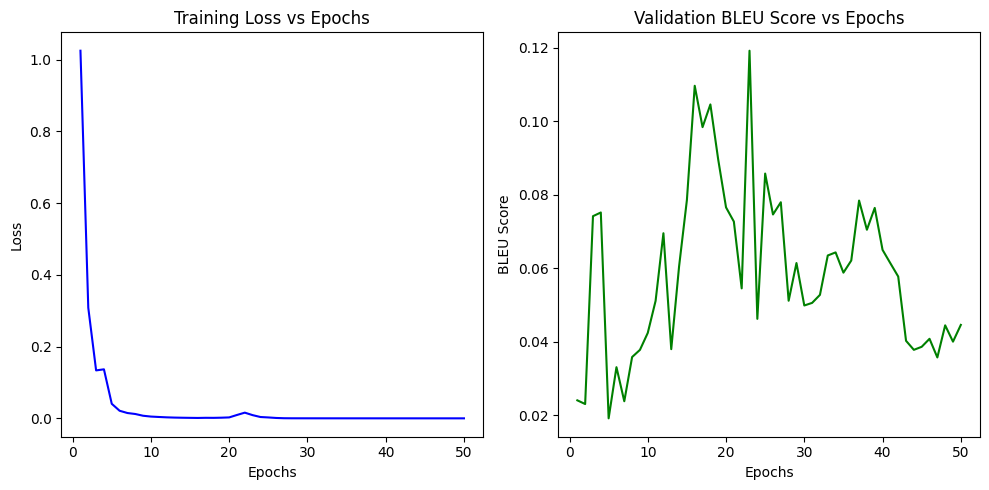

Evaluating model...
Average BLEU Score: 0.0996


In [203]:
fine_tuned_model = fine_tune_t5_model(train_df, val_df, model, tokenizer, epochs=50)

The **BLEU score** ranges from 0 to 1:<br>
1. A BLEU score of 1 means a perfect match between the generated output and reference texts.<br>
2. A BLEU score of 0 means no overlap between the generated output and reference texts.<br>

In practice, BLEU scores typically range between 0 and 1, where scores above 0.7 are generally considered good, but this can vary depending on the task and dataset.


In [204]:
# Test Prediction
new_cve_description = "A vulnerability was found in Netis Netcore Router up to 2.2.6. It has been declared as problematic. Affected by this vulnerability is an unknown functionality of the file param.file.tgz of the component Backup Handler. The manipulation leads to information disclosure. The attack can be launched remotely. The associated identifier of this vulnerability is VDB-217591."
execution_flow = generate_execution_flow(fine_tuned_model, tokenizer, new_cve_description)

print("\nGenerated Execution Flow:")
print(execution_flow)


Generated Execution Flow:
::STEP:1:PHASE:Explore:DESCRIPTION:[Survey the application for stored user-controllable inputs] Using a browser or an automated tool, an adversary follows all public links and actions on a web site. They record all areas that allow a user to upload content through an HTTP POST request. This is typically found in blogs or forums.:TECHNIQUE:Use a spidering tool to follow and record all links and analyze the web pages to find entry points. Make special note of any links that include parameters in the URL.:Tek/UI:On a machine that uses a WS-Referral service, the adversary uses a tool such as the OSX otool utility or manually probes whether the application uses dynamically linked libraries and the configuration of the file or look up table (such as Procedure Linkage Table) which contains the entries for dynamically linked URLs.::


In [205]:
# Assuming you have a fine-tuned model and tokenizer
fine_tuned_model = fine_tuned_model  # Replace with your fine-tuned model variable
fine_tuned_tokenizer = tokenizer  # Replace with your fine-tuned tokenizer variable

# Specify the directory to save the fine-tuned model and tokenizer
output_dir = "./BARTmodel_with_bleu_score"

# Save the model and tokenizer
fine_tuned_model.save_pretrained(output_dir)
fine_tuned_tokenizer.save_pretrained(output_dir)

print(f"Fine-tuned model and tokenizer saved to {output_dir}")

/home/shalini/kmsha_mtp/lib/python3.12/site-packages/transformers/modeling_utils.py:2817: UserWarning: Moving the following attributes in the config to the generation config: {'early_stopping': True, 'num_beams': 4, 'no_repeat_ngram_size': 3, 'forced_bos_token_id': 0}. You are seeing this warning because you've set generation parameters in the model config, as opposed to in the generation config.
  warnings.warn(


Fine-tuned model and tokenizer saved to ./BARTmodel_with_bleu_score


In [206]:
# Load the fine-tuned model and tokenizer
saved_model_dir = "./BARTmodel_with_bleu_score"

# Reload the fine-tuned model and tokenizer
mo = T5ForConditionalGeneration.from_pretrained(saved_model_dir).to("cuda" if torch.cuda.is_available() else "cpu")
to = T5Tokenizer.from_pretrained(saved_model_dir)

print(f"Fine-tuned model and tokenizer loaded from {saved_model_dir}")

NameError: name 'T5ForConditionalGeneration' is not defined

In [ ]:
# Test Prediction
new_cve_description = "A vulnerability was found in Netis Netcore Router up to 2.2.6. It has been declared as problematic. Affected by this vulnerability is an unknown functionality of the file param.file.tgz of the component Backup Handler. The manipulation leads to information disclosure. The attack can be launched remotely. The associated identifier of this vulnerability is VDB-217591."
execution_flow = generate_execution_flow(mo, to, new_cve_description)

print("\nGenerated Execution Flow:")
print(execution_flow)